# Using the covariance to instil physical insight during model construction

In the first part of this course we have introduced the prior covariance $\mathbf{\Sigma}_0$ (see [Section 2.2 of the lecture notes](https://tif345.materialsmodeling.org/bayesian_inference/a_conjugate_prior.html)).
While this is in a general matrix, so far we mostly treated it as a scalar, i.e. we set $\mathbf{\Sigma}_0=\sigma\mathbf{1}$, where $\sigma$ is the standard deviation.
The (learning) objective of this notebook is to demonstrate that the covariance matrix is an even more powerful concept and allows us to insert physical insights into our model.
Here, we will use in particular the off-diagonal components to introduce coupling between parameters.
In project 2a you will use similar physical insight to set up the diagonal elements of the covariance matrix.

Specifically, we consider a cluster expansion for a surface, which serves as an example for a model with physically intuitive and interpretable parameters.
In the following, we first set up a conventional (standard) cluster space and analyze the orbits in order to determine which of them we deem to be related.
Next we create a custom cluster space by explicitly merging orbits, which is a special feature of [`icet`](https://icet.materialsmodeling.org/) that we use here for demonstration only.
It corresponds to the extreme limit in which two parameters are forced to be exactly identical, and here only serves as a reference point for the covariance approach.
We then return to the original cluster space and set up a covariance that reflects our understanding of the system.
Finally, we compare the ECIs from the different approaches.

The approach taken here follows the procedure described in [Physical Review B **80**, 024103 (2009)](https://doi.org/10.1103/PhysRevB.80.024103).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from ase.db import connect
from icet import ClusterExpansion, ClusterSpace, StructureContainer
from pandas import DataFrame

## Standard cluster space

Our system of interest is the (100) surface of a Au-Pd alloy.
The surface is modeled as an 8-layer slab.
For simplicity and clarity of the following presentation, we consider an extremely simple [cluster space](https://icet.materialsmodeling.org/moduleref_icet/cluster_space.html) that only includes first and second nearest pairs.
Such a small space is insufficient to accurately capture the energetics of any realistic system but due to the symmetry breaking induced by surface, already this very reduced space has 20 parameters.

In [2]:
db = connect('prototype-surface-structures.db')
prim = db.get('Au=8,Pd=0').toatoms()
prim.pbc = True
cs = ClusterSpace(prim, cutoffs=[4.1], chemical_symbols=['Au', 'Pd'])
print(cs)

====================================== Cluster Space ======================================
 space group                            : P4/nmm (129)
 chemical species                       : ['Au', 'Pd'] (sublattice A)
 cutoffs                                : 4.1000
 total number of parameters             : 20
 number of parameters by order          : 0= 1  1= 4  2= 15
 fractional_position_tolerance          : 2e-06
 position_tolerance                     : 1e-05
 symprec                                : 1e-05
-------------------------------------------------------------------------------------------
index | order |  radius  | multiplicity | orbit_index | multicomponent_vector | sublattices
-------------------------------------------------------------------------------------------
   0  |   0   |   0.0000 |        1     |      -1     |           .           |      .     
   1  |   1   |   0.0000 |        2     |       0     |          [0]          |      A     
   2  |   1   |   0.0000 

## Analyze orbits

To determine which orbits are present and how they are related, we check their size (radius) and whether their respective representative clusters contain at least one surface site.

,index,order,radius,multiplicity,orbit_index,multicomponent_vector,sublattices
0,0,0,0.000000,1,-1,.,.
1,1,1,0.000000,2,0,[0],A
2,2,1,0.000000,2,1,[0],A
3,3,1,0.000000,2,2,[0],A
4,4,1,0.000000,2,3,[0],A
5,5,2,1.442498,4,4,"[0, 0]",A-A
6,6,2,1.442498,4,5,"[0, 0]",A-A
7,7,2,1.442498,4,6,"[0, 0]",A-A
8,8,2,1.442498,4,7,"[0, 0]",A-A
9,9,2,1.442498,4,8,"[0, 0]",A-A


In [13]:
orbit_data = DataFrame.from_dict(cs.orbit_data)
zsurfs = [10, 24.48]
for k in range(len(cs) - 1):
    positions = cs.get_coordinates_of_representative_cluster(k)
    if any([any([np.isclose(pos[2], z, atol=2) for z in zsurfs]) for pos in positions]):
        print(f'surface', end='')
    else:
        print(f'bulk   ', end='')
    print(f'  {k:2}  {orbit_data.iloc[k].radius:7.2f}:  ', end='')
    for pos in positions:
        print(f'   {pos[0]:7.2f} {pos[1]:7.2f} {pos[2]:7.2f}', end='')
    print('')

surface   0     0.00:        1.44    1.44   10.00
bulk      1     0.00:        0.00    0.00   12.04
bulk      2     0.00:        1.44    1.44   14.08
bulk      3     0.00:        0.00    0.00   16.12
surface   4     0.00:       -1.44    1.44   10.00      1.44    1.44   10.00
bulk      5     1.44:       -2.88    0.00   12.04      0.00    0.00   12.04
bulk      6     1.44:       -1.44    1.44   14.08      1.44    1.44   14.08
bulk      7     1.44:       -2.88    0.00   16.12      0.00    0.00   16.12
bulk      8     1.44:        0.00    0.00   16.12     -1.44   -1.44   18.16
surface   9     1.44:       -1.44   -1.44   10.00      0.00    0.00   12.04
bulk     10     1.44:        0.00    0.00   12.04     -1.44   -1.44   14.08
bulk     11     1.44:       -1.44   -1.44   14.08      0.00    0.00   16.12
surface  12     1.44:        1.44    1.44   10.00      1.44    1.44   14.08
bulk     13     2.04:        0.00    0.00   12.04      0.00    0.00   16.12
bulk     14     2.04:        1.44    1.4

The above analysis allows us to categorize the orbits as follows.

#### Singlets

| Orbit indices  | Description           |
|----------------|-----------------------|
| 0              | Surface singlet       |
| 1,2,3          | Bulk (layers 2, 3, 4) |

#### Pairs

| Orbit  indices | Description                                 |
|----------------|---------------------------------------------|
| 4              | Surface nearest neighbor in-plane           |
| 9              | Surface-bulk nearest neighbor out-of-plane  |
| 15             | Surface second-nearest neighbor in-of-plane |
| 5, 6, 7, 8     | Bulk nearest-neighbor in-plane              |
| 10, 11         | Bulk nearest neighbor out-of-plane          |
| 13, 14         | Bulk second nearest neighbor out-of-plane   |
| 16, 17, 18     | Bulk second nearest neighbor in-plane       |

## Cluster expansion with explicitly merged orbits

Based on the analysis of the orbits above, we here decide which orbits to combine (merge).
The `merge_info` dictionary is also used further below to build up the covariance matrix.
The dictionary keys indicate which orbit we use as the representative one, when merging whereas the dictionary values specify the indices of the orbits to be merged into the representative one.
The `group_labels` dictionary is used for plotting and analysis below.

In [14]:
merge_info = {2: [3],
              6: [7, 8, 10, 11],
              13: [14, 16, 17, 18]}
group_labels = {'singlets': [0, 1, 2, 3],
                'pairs, surface': [4, 9, 15],
                'pairs, bulk, 1nn': [5, 6, 7, 8, 10, 11],
                'pairs, bulk, 2nn': [13, 14, 16, 17, 18]}

cs_merged = ClusterSpace(prim, cutoffs=[4.1], chemical_symbols=['Au', 'Pd'])
cs_merged.merge_orbits(merge_info)
print(cs_merged)

====================================== Cluster Space ======================================
 space group                            : P4/nmm (129)
 chemical species                       : ['Au', 'Pd'] (sublattice A)
 cutoffs                                : 4.1000
 total number of parameters             : 11
 number of parameters by order          : 0= 1  1= 3  2= 7
 fractional_position_tolerance          : 2e-06
 position_tolerance                     : 1e-05
 symprec                                : 1e-05
-------------------------------------------------------------------------------------------
index | order |  radius  | multiplicity | orbit_index | multicomponent_vector | sublattices
-------------------------------------------------------------------------------------------
   0  |   0   |   0.0000 |        1     |      -1     |           .           |      .     
   1  |   1   |   0.0000 |        2     |       0     |          [0]          |      A     
   2  |   1   |   0.0000 |

As a result of the merging the number of model parameters is reduced from 20 to 11.

Next we compile [structure containers](https://icet.materialsmodeling.org/moduleref_icet/structure_container.html) based on both the standard and the merged cluster space.

In [15]:
sc = StructureContainer(cluster_space=cs)
sc_merged = StructureContainer(cluster_space=cs_merged)
db = connect('prototype-surface-structures.db')
for row in db.select('natoms<=16'):
    structure = row.toatoms()
    structure.pbc = True
    sc.add_structure(structure, user_tag=f'{row.id}', properties={'mixing_energy': row.mixing_energy})
    sc_merged.add_structure(structure, user_tag=f'{row.id}', properties={'mixing_energy': row.mixing_energy})

We select all structures with 8 atoms as well as randomly 10 structures with 16 atoms.

In [16]:
structure_indices = [k for k, s in enumerate(sc) if len(s) == 8]
ixs = [k for k, s in enumerate(sc) if len(s) == 16]
structure_indices.extend(np.random.choice(ixs, 10))

structure_indices = np.random.choice(range(len(sc)), 10)

First we solve $\mathbf{A}\boldsymbol{x} = \boldsymbol{y}$ via OLS.
This is done here by using the [pseudoinverse](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.pinv.html) and hence singular value decomposition (SVD).

$$
\boldsymbol{x} = (\mathbf{A}^T \mathbf{A})^{-1} \mathbf{A}^T \boldsymbol{y}
$$

We begin with the standard cluster space.

In [17]:
def get_validation_score(ce):
    e_diff = []
    data = []
    for row in db.select('natoms<=24'):
        e_diff.append((row.mixing_energy - ce.predict(row.toatoms()))**2)
        data.append(row.mixing_energy)

    return np.sqrt(np.average(e_diff)), np.std(data)


A, y = sc.get_fit_data(structure_indices=structure_indices, key='mixing_energy')
x_OLS = np.dot(scipy.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, y))
ce_OLS = ClusterExpansion(parameters=x_OLS, cluster_space=cs)
print('validation OLS', get_validation_score(ce_OLS))

validation OLS (0.002298164526054211, 0.007055638550260422)


Then we repeat the process using the merged cluster space.
We also convert the merged ECIs back to their "standard" form in order to enable ECI comparison between standard and merge cluster expansions.

In [18]:
def get_index_in_merged_cluster_space(index, merge_info):
    count = 0
    for indices in merge_info.values():
        for ind_comp in indices:
            if index > ind_comp:
                count += 1
    return index - count

# merged cluster space
A, y = sc_merged.get_fit_data(structure_indices=structure_indices, key='mixing_energy')
x_OLS_merged = np.dot(scipy.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, y))

# ... then unfold the ECIs from the merged cluster space in order to plot them properly
x_OLS_merged_unfolded = [0] * len(cs)
for i in range(len(cs)):
    for key, val in merge_info.items():
        if i - 1 in val or i - 1 == key: # -1  because of zerolet
            ind = get_index_in_merged_cluster_space(key + 1, merge_info)
            mult_bef = cs.orbit_data[i]['multiplicity']
            mult_after = cs_merged.orbit_data[ind]['multiplicity']
            x_OLS_merged_unfolded[i] = x_OLS_merged[ind] * mult_bef / mult_after
            break
    else:
        x_OLS_merged_unfolded[i] = x_OLS_merged[get_index_in_merged_cluster_space(i, merge_info)]
        x_OLS_merged_unfolded = np.array(x_OLS_merged_unfolded)

ce_unfolded = ClusterExpansion(parameters=x_OLS_merged_unfolded, cluster_space=cs)
ce_merged = ClusterExpansion(parameters=x_OLS_merged, cluster_space=cs_merged)
print('validation merged', get_validation_score(ce_unfolded), get_validation_score(ce_merged))

validation merged (0.0016919756414033775, 0.007055638550260422) (0.0016919756414033773, 0.007055638550260422)


Now we use the covariance approach to constrain the cluster space, following the approach described in [Physical Review B **80**, 024103 (2009)](https://doi.org/10.1103/PhysRevB.80.024103).
This means that we now obtain the optimal parameters by evaluating
$$
\boldsymbol{x} = (\mathbf{A}^T \mathbf{A} + \mathbf{\Lambda})^{-1} \mathbf{A}^T \boldsymbol{y}.
$$

Here, $\mathbf{\Lambda}=\mathbf{\Sigma}_0^{-1}$ is the inverse of the covariance matrix, which we construct such that the orbits that we marked above for merging are coupled to each other.
The elements of $\mathbf{\Lambda}$ are given by
$$
\Lambda_{\alpha,\alpha} = \frac{\sigma^2}{\sigma_\alpha^2} + \sum_{\beta | \beta\neq\alpha} \frac{\sigma^2}{\sigma_{\alpha\beta}}\\
\Lambda_{\alpha\beta} = \Lambda_{\beta\alpha} = - \frac{\sigma^2}{\sigma_{\alpha\beta}^2}.
$$
We choose $\sigma_\alpha$ (`sigma_a` in the code below) to be the same for all orbits/ECIs and we choose $\sigma_{\alpha\beta}$ (`sigma_ab` in the code below) to be finite and identical for all orbit pairs that we want to couple and zero for all other combinations.

It is useful to consider the extremal cases for the elements of $\mathbf{\Lambda}$, using the reduced values $\lambda_{\alpha}=\sigma^2/\sigma_\alpha^2$ and  $\lambda_{\alpha\beta}=\sigma^2/\sigma_{\alpha\beta}^2$.

1. $\lambda_{\alpha} \rightarrow \infty$: force ECI for orbit $\alpha$ to zero (= remove orbit)
1. $\lambda_{\alpha} \rightarrow 0$ and $\lambda_{\alpha\beta} \rightarrow 0$: all ECIs/orbits are equally likely; this recovers OLS
1. $\lambda_{\alpha\beta} \rightarrow 0$: no correlation (coupling) between orbits; this recovers ridge regression if $\lambda_\alpha$ is the same for all orbits
1. $\lambda_{\alpha\beta} \rightarrow \infty$: force two orbits to have the same ECI

To explore the effect of the choice of `sigma_ab` on the ECIs and the CV-RMSE score below we carry out a scan over a range of values.

In [19]:
# parameters for covariance matrix
sigma = 2
sigma_a = 1e5

# prepare construction of covariance matrix
orbit_groups_to_couple = []
for repr_orbit, orbits in merge_info.items():
    orbit_groups_to_couple.append([repr_orbit] + orbits)

A, y = sc.get_fit_data(structure_indices=structure_indices, key='mixing_energy')
N = A.shape[1]

xs_OLS_cov = {}
results = {}
for sigma_ab in np.logspace(-3, 8, num=3*11+1):

    # construct covariance matrix
    cov = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            for orbit_group in orbit_groups_to_couple:
                if i - 1 in orbit_group and j - 1 in orbit_group:  # -1 because of zerolet
                    cov[i, j] = - sigma ** 2 / sigma_ab ** 2
                    cov[j, i] = cov[i, j]
    for i in range(N):
        cov[i, i] = sigma ** 2 / sigma_a ** 2 - np.sum(cov[i, :])

    # fit ECIs
    xs_OLS_cov[sigma_ab] = np.dot(scipy.linalg.pinv(np.dot(A.T, A) + cov), np.dot(A.T, y))
    ce_cov = ClusterExpansion(parameters=xs_OLS_cov[sigma_ab], cluster_space=cs)
    cv_rmse, sdv_data = get_validation_score(ce_cov)
    results[sigma_ab] = {'cv_rmse': cv_rmse, 'sdv_data': sdv_data}
    print(f'validation covariance: {sigma_ab:.3e} {1e3*cv_rmse:.4f}')

validation covariance: 1.000e-03 1.4987
validation covariance: 2.154e-03 1.4987
validation covariance: 4.642e-03 1.4987
validation covariance: 1.000e-02 1.4987
validation covariance: 2.154e-02 1.4916
validation covariance: 4.642e-02 1.4987
validation covariance: 1.000e-01 1.4982
validation covariance: 2.154e-01 1.4960
validation covariance: 4.642e-01 1.4877
validation covariance: 1.000e+00 1.4717
validation covariance: 2.154e+00 1.5459
validation covariance: 4.642e+00 1.7965
validation covariance: 1.000e+01 2.0187
validation covariance: 2.154e+01 2.1545
validation covariance: 4.642e+01 2.2051
validation covariance: 1.000e+02 2.2180
validation covariance: 2.154e+02 2.2210
validation covariance: 4.642e+02 2.2216
validation covariance: 1.000e+03 2.2217
validation covariance: 2.154e+03 2.2215
validation covariance: 4.642e+03 2.2207
validation covariance: 1.000e+04 2.2171
validation covariance: 2.154e+04 2.2005
validation covariance: 4.642e+04 2.1316
validation covariance: 1.000e+05 1.9337


We can now plot the variation of the CV-RMSE score with `sigma_ab`.

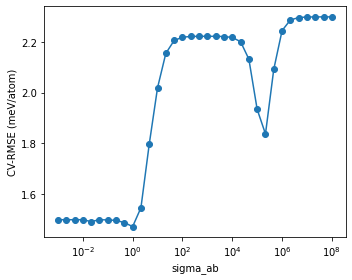

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))
df = DataFrame.from_dict(results).T.sort_index()

ax.semilogx(1e3 * df.cv_rmse, 'o-')
ax.set_xlabel('sigma_ab')
ax.set_ylabel('CV-RMSE (meV/atom)')

plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

We can identify three distinct regions in the CV-RMSE scan.
Below we plot the ECIs for these situations, which shows that the extrema respectively are close to the standard (unconstrained OLS) solution and the cluster space with explicitly merged orbits, while the intermediate value of `sigma_ab` provides a balanced intermediate solution.
(N.B.: The position and shape of the minimum can change with the selection of training structures.)

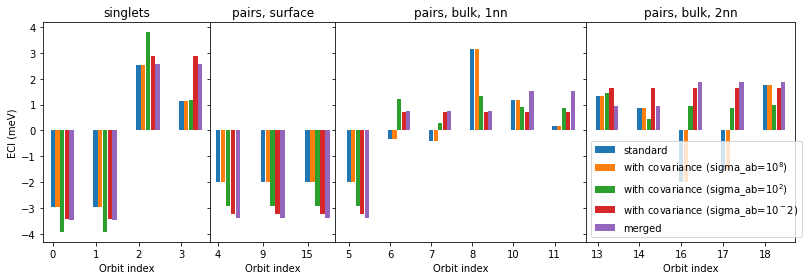

In [21]:
widths = [len(g) for g in group_labels.values()]
fig, axes = plt.subplots(ncols=len(group_labels), figsize=(12, 4), sharey=True, gridspec_kw=dict(width_ratios=widths))

wdt = 0.1
shift = wdt + 0.01

selected_sigma_abs = [1e8, 1e2, 1e-2]  # , 4.6415888336127775

for icol, (ax, (label, group)) in enumerate(zip(axes, group_labels.items())):
    shifted_group = np.array(group) + 1  # adjust index to account for zerolet
    pos = np.array(range(len(x_OLS[shifted_group]))) + 1
    ax.bar(pos, 1e3 * x_OLS[shifted_group], width=wdt, label='standard')
    for k, sigma_ab in enumerate(selected_sigma_abs, start=1):
        ax.bar(pos + k * shift, 1e3 * xs_OLS_cov[sigma_ab][shifted_group], width=wdt,
               label=f'with covariance (sigma_ab=$10^{np.log10(sigma_ab):.0f}$)')
    ax.bar(pos + (k + 1) * shift, 1e3 * x_OLS_merged_unfolded[shifted_group], width=wdt, label='merged')
    ax.set_title(label)
    if icol == 0:
        ax.set_ylabel('ECI (meV)')
    ax.set_xlabel('Orbit index')
    ax.set_xticks(pos)
    ax.set_xticklabels(group)

ax.legend()

plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
fig.align_ylabels(axes)

The above example is a very simple case but nonetheless illustrates the power of the covariance matrix for model construction.
Here, we had the luxury of having a custom implementation that introduces an explicit and exact coupling of parameters (the merged cluster space), which is in general not available.
It also requires very specific "black-and-white" choices on behalf of the model builder.
In this context, the covariance approach allows for "gray" answers that can be found through model selection among a range of choices for the parameters in the covariance matrix.

## Some follow-up questions for you to consider

* Can you interpret the singlet energies?
* Can you anticipate what happens to the OLS solution if you reduce the number of training structures?
* As discussed in the lecture notes as well as [Physical Review B **80**, 024103 (2009)](https://doi.org/10.1103/PhysRevB.80.024103), there are additional physical insights that can be used here, regarding, e.g., the decay of the ECIs with distance. How would you introduce these considerations here?